In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import BatchNormalization,Dense, Reshape, Dropout # type: ignore
from tensorflow.keras.regularizers import l2
from keras import regularizers
import os
import pydot
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 偏振光谱训练

In [3]:
powersopwave_loaded=np.loadtxt("HD_inputdataset.csv", delimiter=",")
N=len(powersopwave_loaded)
array_2d_loaded = np.loadtxt("HD_outputdataset.csv", delimiter=",")
sopwave_loaded = array_2d_loaded.reshape(N, 81, 4)

In [4]:
#train, validation and test sets division
alpha=0.7
beta=0.8
inputs_all =powersopwave_loaded
targets_all=sopwave_loaded
inputs_train=inputs_all[0:int(N*alpha)]
targets_train=targets_all[0:int(N*alpha)]
inputs_val=inputs_all[int(N*alpha):int(N*beta)]
targets_val=targets_all[int(N*alpha):int(N*beta)]
inputs_test=inputs_all[int(N*beta):]
targets_test=targets_all[int(N*beta):]

np.random.seed(11)
np.random.shuffle(inputs_train)
np.random.seed(11)
np.random.shuffle(targets_train)

np.random.seed(14)
np.random.shuffle(inputs_val)
np.random.seed(14)
np.random.shuffle(targets_val)

Epoch 1/1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1429 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0302 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 8/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 9/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 10/1000
55/55 ━━━

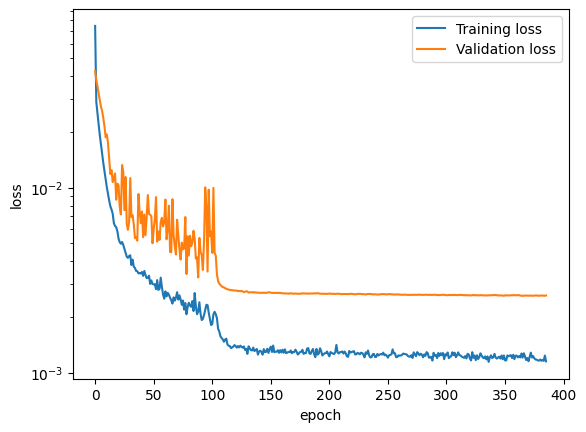

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=16, activation='relu',kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(200, activation='relu',kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(350, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(400, activation='tanh'))
# model.add(BatchNormalization())
model.add(Dense((81*4)))
model.add(Reshape((81, 4)))

model.compile(loss='mean_squared_error', optimizer='adamw')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=15, min_lr=1e-6)

history = model.fit(inputs_train, targets_train, epochs=1000, batch_size=64, 
                    validation_data=(inputs_val, targets_val),
                    callbacks=[early_stopping, lr_scheduler])
mse = model.evaluate(inputs_val, targets_val)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

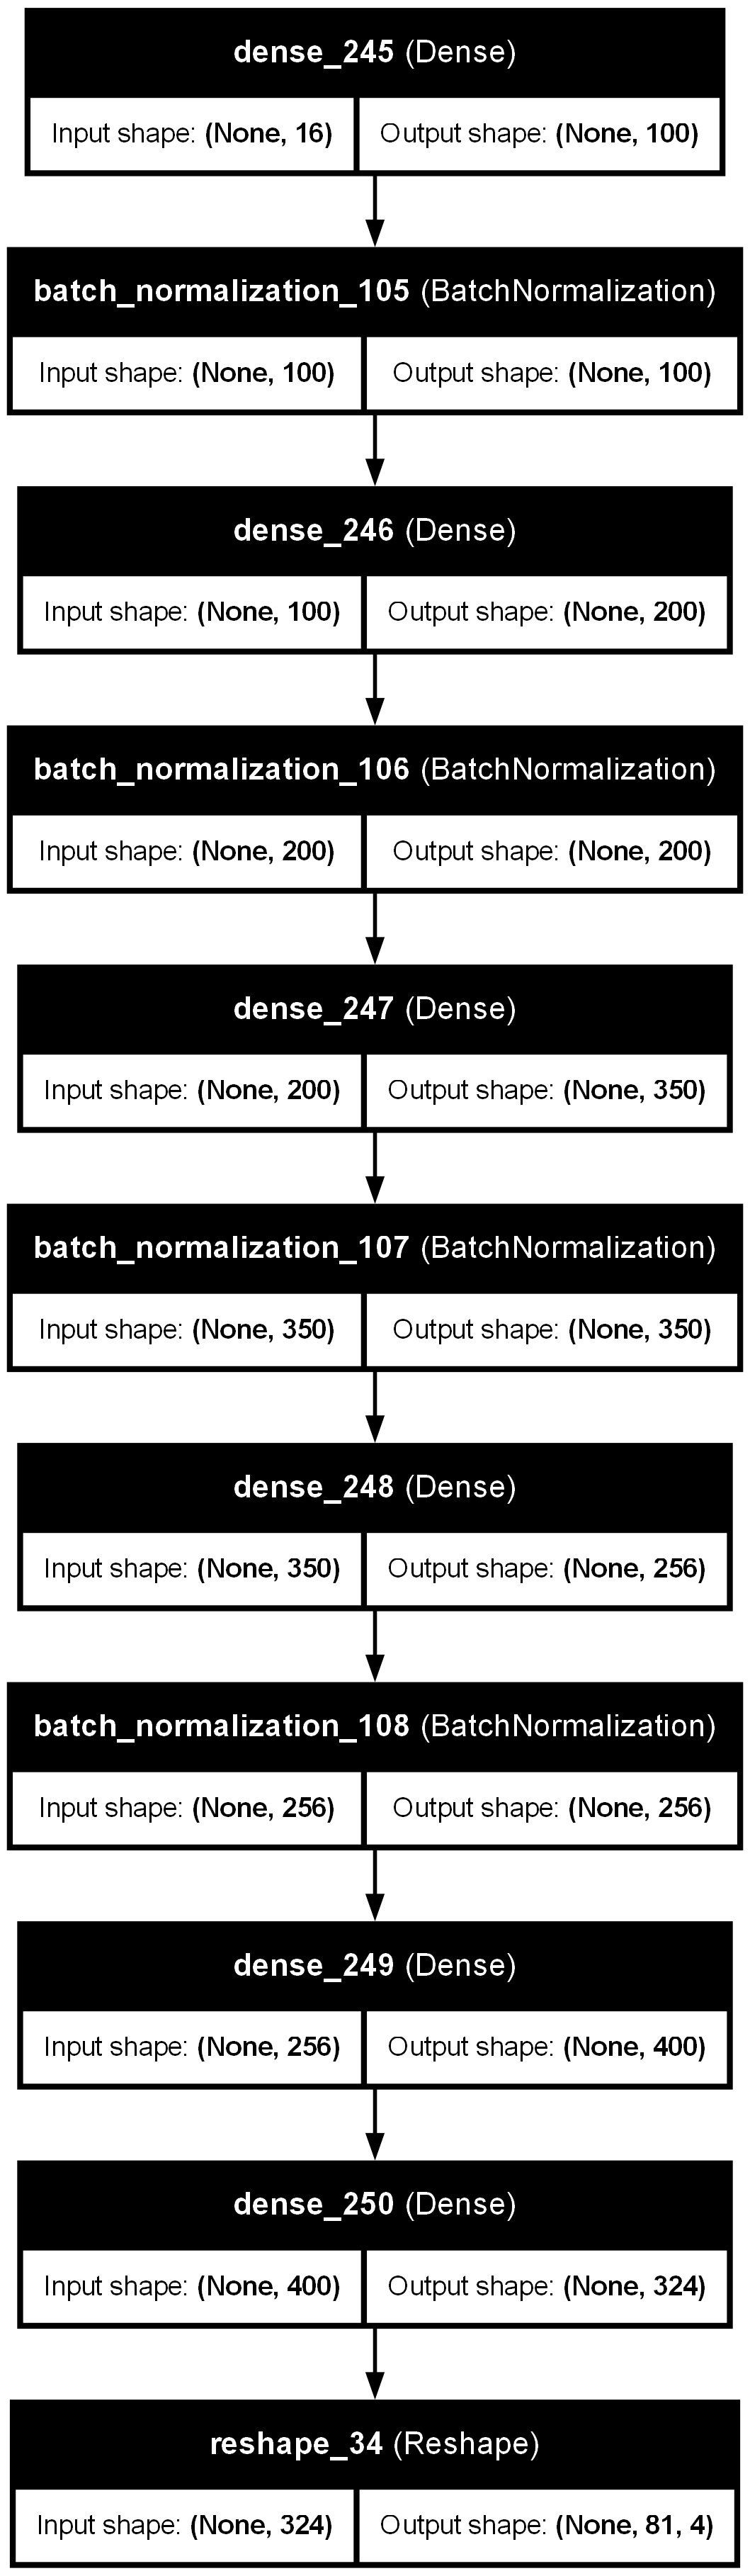

In [10]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
# 显示 SVG 图像
dot = model_to_dot(model, show_shapes=False, show_layer_names=True, dpi=60)
SVG(dot.create(prog='dot', format='svg'))
plot_model(model, to_file='HDmodel0.01_0.0024.png', show_shapes=True, show_layer_names=True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
spectra mean error: 0.30347427789420733
均方误差 (MSE): 0.024601377550405965
i-th error: 0.08201974245217605


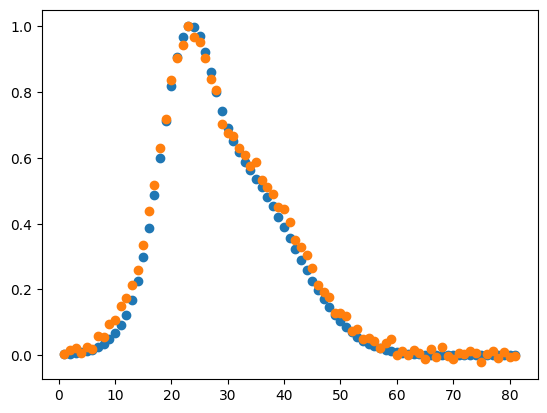

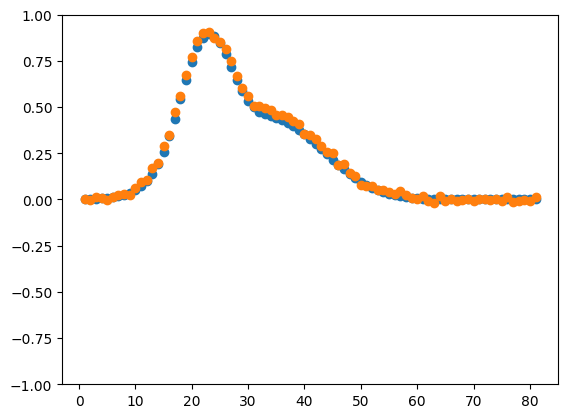

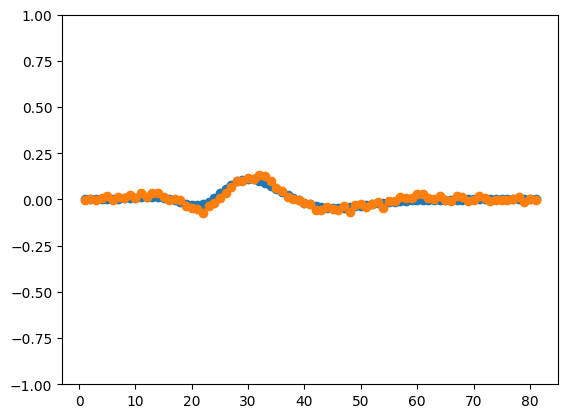

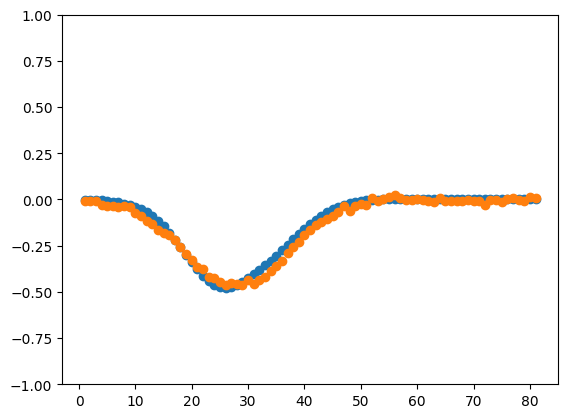

In [ ]:

spectpoint=81
L=np.arange(start=1,stop=spectpoint+1,step=1)
targets_pre=model.predict(inputs_test)
targets=targets_test

max_values = np.max(targets_pre[:, :, 0], axis=1)
targets_pre=np.divide(targets_pre,max_values.reshape(1000,1,1) )

max_values = np.max(targets[:, :, 0], axis=1)
targets=np.divide(targets,max_values.reshape(1000,1,1) )

errors = []
for ith in range(targets.shape[0]):
    iL1mse = np.linalg.norm(targets[ith,:,0] - targets_pre[ith,:,0],1) / np.linalg.norm(targets[ith,:,0],1)
    errors.append(iL1mse)
average_error = np.mean(errors)
print(f"spectra mean error: {average_error}")
plt.figure(1)
ith=370
plt.scatter(L,targets[ith,0:spectpoint,0])
plt.scatter(L,targets_pre[ith,0:spectpoint,0])
plt.figure(2)
plt.scatter(L,targets[ith,0:spectpoint,1])
plt.scatter(L,targets_pre[ith,0:spectpoint,1])
plt.ylim(-1, 1)  
plt.figure(3)
plt.scatter(L,targets[ith,0:spectpoint,2])
plt.scatter(L,targets_pre[ith,0:spectpoint,2])
plt.ylim(-1, 1)  
plt.figure(4)
plt.scatter(L,targets[ith,0:spectpoint,3])
plt.scatter(L,targets_pre[ith,0:spectpoint,3])
plt.ylim(-1, 1)  

mse = np.mean((targets - targets_pre) ** 2)
print("均方误差 (MSE):", mse)

iL1mse = np.linalg.norm(targets[ith,:,0] - targets_pre[ith,:,0],1)/np.linalg.norm(targets[ith,:,0 ],1)
print("i-th error:", iL1mse)

S0参数的误差: 0.021053709029253943
S1参数的误差: 0.014450679710292649
S2参数的误差: 0.01163203522145388
S3参数的误差: 0.020811641835497455


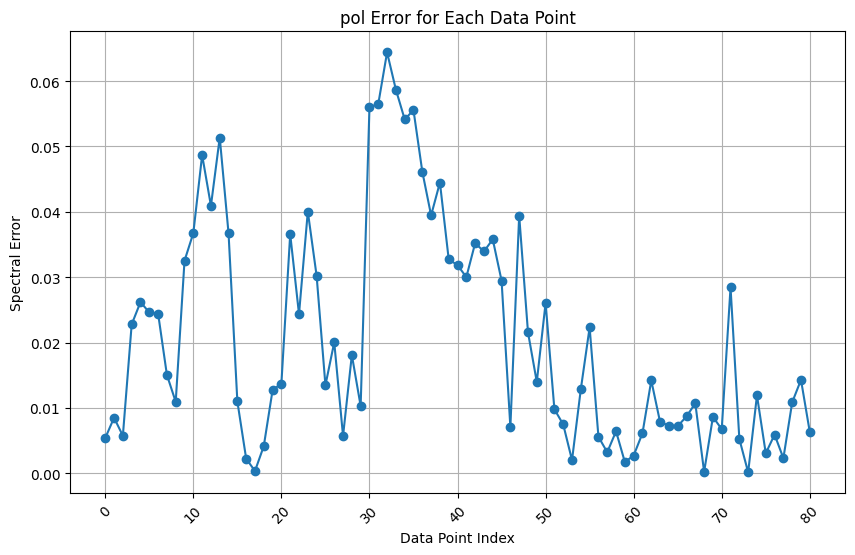

In [8]:
# error
S0_pre, S1_pre, S2_pre, S3_pre = targets_pre[ith,:, 0], targets_pre[ith,:, 1], targets_pre[ith,:, 2], targets_pre[ith,:, 3]
S0_true, S1_true, S2_true, S3_true = targets[ith,:, 0], targets[ith,:, 1], targets[ith,:, 2], targets[ith,:, 3]

# 获取样本数量
N = len(S0_pre)
# 分别计算S0 - S3的误差
errors_S0 = np.abs((S0_pre - S0_true))if np.any(S0_true != 0) else 0
errors_S1 = (np.abs((S1_pre - S1_true)))  if np.any(S1_true != 0) else 0
errors_S2 = (np.abs((S2_pre - S2_true))) if np.any(S2_true != 0) else 0
errors_S3 = (np.abs((S3_pre - S3_true)))  if np.any(S3_true != 0) else 0

# 分别计算S0 - S3的平均误差
average_error_S0 = np.mean(errors_S0)
average_error_S1 = np.mean(errors_S1)
average_error_S2 = np.mean(errors_S2)
average_error_S3 = np.mean(errors_S3)

print("S0参数的误差:", average_error_S0)
print("S1参数的误差:", average_error_S1)
print("S2参数的误差:", average_error_S2)
print("S3参数的误差:", average_error_S3)

plt.figure(figsize=(10, 6))
plt.plot(range(N), errors_S3, marker='o', linestyle='-')
plt.title('pol Error for Each Data Point')
plt.xlabel('Data Point Index')
plt.xticks(rotation=45)
plt.ylabel('Spectral Error')
plt.grid(True)